In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from tqdm.notebook import tqdm
from matplotlib import font_manager
import pickle

Matplotlib style code:

In [3]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
})

font_path = 'helvetica.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['text.color'] = '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'
plt.rcParams['axes.labelcolor'] = '#000000'
plt.rcParams['pdf.fonttype'] = 42

def leading_zeros_formatter(x, pos):
    """Format 1 as 1, 0 as 0, and all values whose absolute values is between
    0 and 1 without the leading "0." (e.g., 0.7 is formatted as .7 and -0.4 is
    formatted as -.4)."""
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str

In [4]:
df = pd.read_csv("predictions.csv")

In [5]:
df = df.sort_values(['indices', 'Unnamed: 0'])[['Unnamed: 0', 'indices', 'labels', 'preds', 'birads', 'birads_granular']]

In [9]:
df_new = pd.DataFrame()
df_new['indices'] = df.indices.values[::2]
df_new['preds_lm'] = df.preds.values[::2]
df_new['preds_rm'] = df.preds.values[1::2]
df_new['label_lm'] = df.labels.values[::2]
df_new['label_rm'] = df.labels.values[1::2]
df_new['birads'] = df.birads.values[::2]
df_new['birads_granular'] = df.birads_granular.values[::2]
df_new['malignant'] = df_new[['label_lm', 'label_rm']].max(axis=1)

df_new[['preds_lm', 'preds_rm', 'label_lm', 'label_rm', 'birads', 'birads_granular', 'malignant']].head()

,preds_lm,preds_rm,label_lm,label_rm,birads,birads_granular,malignant
0,0.201515,0.005247,0,0,4,4b,0
1,0.023558,0.879841,0,0,4,4a,0
2,0.030466,0.468097,0,0,0,NaN,0
3,0.802926,0.107109,1,0,6,NaN,1
4,0.904911,0.026669,1,0,0,NaN,1


In [10]:
x = []
y = []
thresholds = []
missed_cancers_set = set()
for threshold in tqdm(np.arange(0.00, 0.50, 0.01)):
    missed_cancers = 0
    correctly_downgraded = 0
    correctly_detected = 0
    false_positive = 0
    birads_df = df_new[df_new.birads=='4']

    for _, row in birads_df.iterrows():
        pred_malignant = ((row.preds_lm > threshold) | (row.preds_rm > threshold))

        if pred_malignant == False and row.malignant == False:
            correctly_downgraded += 1
        if pred_malignant == False and row.malignant == True:
            missed_cancers += 1
            missed_cancers_set.add(row.indices)
        if pred_malignant == True and row.malignant == True:
            correctly_detected += 1
        if pred_malignant == True and row.malignant == False:
            false_positive += 1
    x.append(missed_cancers)
    y.append(correctly_downgraded)
    thresholds.append(threshold)

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
tradeoff = pd.DataFrame()
tradeoff['x'] = x
tradeoff['y'] = y
tradeoff['threshold'] = thresholds
tradeoff.head()

,x,y,threshold
0,0,0,0.00
1,3,43,0.01
2,5,99,0.02
3,15,134,0.03
4,23,163,0.04


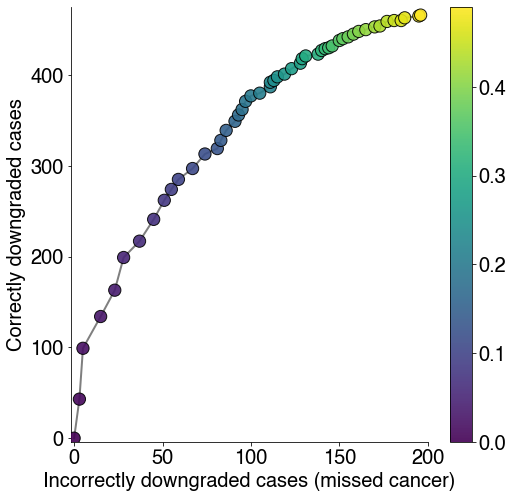

In [12]:
#Plot
plt.figure(figsize=(8,8))
plt.plot(x, y, lw=2, color='black', alpha=0.5)
plt.scatter(x=x, y=y, s=150, c=np.arange(0.00, 0.50, 0.01), edgecolors='black', zorder=999, alpha=0.9)
plt.xlabel("Incorrectly downgraded cases (missed cancer)")
plt.ylabel("Correctly downgraded cases")
plt.xlim(-2,200)  #B4
plt.ylim(-4,475)  #B4
#plt.xlim(-1,7)  #B3
#plt.ylim(-4,350)  #B3

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_formatter(leading_zeros_formatter)
ax.yaxis.set_major_formatter(leading_zeros_formatter)
plt.colorbar()
#plt.savefig('birads3_downgrading.pdf', bbox_inches='tight')

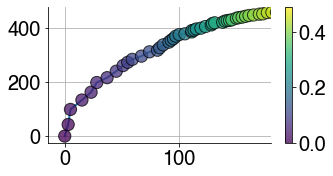

In [13]:
# MINI BI-RADS 4 PLOT
plt.figure(figsize=(5,2.5))
plt.plot(x, y, lw=2)
plt.scatter(x=x, y=y, s=150, c=np.arange(0.00, 0.50, 0.01), edgecolors='black', zorder=999, alpha=0.75)
plt.xlim(-15,180)
plt.ylim(-25,480)
plt.grid()
ax = plt.gca()
#ax.set_xticks([0, 25, 50, 75])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_formatter(leading_zeros_formatter)
ax.yaxis.set_major_formatter(leading_zeros_formatter)
plt.colorbar()
#plt.savefig('birads4_downgrading_mini.pdf', bbox_inches='tight')